---
title: "Data 221 Project"
author: "Aadharsh Pannirselvam and Jei Ho"
date: "5/2/23"
format:
    pdf:
        fig-dpi: 300
---

In [11]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (
    Dense,
    Embedding,
    Conv1D,
    MaxPooling1D,
    Flatten,
    Dropout,
)
from tensorflow.keras.models import Sequential
import os

frame this as being a case study in how we handle real world data that is dynamic and not necessarily represented by our train and even test datasets. We start with a massive tweet dataset, and then test on tweets on apple products after doing a bunch of the ntlk tricks, which drastically lowers our effectiveness. conclude that there isn't really a substitute for representative train data, even if it needs to be fed dynamically as cheating a little and mixing just a few of these tweets to our train dataset seems to improve things when trading off computational intensity on the algo side?

In [12]:
data = pd.read_csv("dataset.csv")
data = data.query("Language == 'en'")
data = data[(data.Label == "negative") | (data.Label == "positive")]
data["target"] = data["Label"].apply(lambda x: 1 if x == "positive" else 0)
apple_data = pd.read_csv("apple_tweets.csv")
apple_data = apple_data[apple_data.sentiment != 0]  # taking out neutral tweets
apple_data.loc[apple_data["sentiment"] == -1, "sentiment"] = 0
stop_words = set(stopwords.words("english"))


def clean_text(text):
    text = re.sub(r"http\S+", "", text)  # remove URLs
    text = re.sub(r"[^a-zA-Z]", " ", text)  # remove non-alphabetic characters
    text = text.lower()  # convert to lowercase
    tokens = word_tokenize(text)  # tokenize text
    stop_words = set(stopwords.words("english"))  # get stop words
    filtered_tokens = [
        token for token in tokens if token not in stop_words
    ]  # remove stop words
    lemmatizer = WordNetLemmatizer()  # create lemmatizer
    lemmatized_tokens = [
        lemmatizer.lemmatize(token) for token in filtered_tokens
    ]  # lemmatize words
    return " ".join(lemmatized_tokens)


data["Text"] = data["Text"].apply(clean_text)
data = data.drop(["Language"], axis=1)
apple_data["text"] = apple_data["text"].apply(clean_text)

## Naive Bayesian Classifier

In [13]:
train_data, test_data, train_target, test_target = train_test_split(
    data.drop("target", axis=1),
    data["target"],
    stratify=data["target"],
    test_size=0.2,
    random_state=42,
)
t0 = train_data.query("Label=='negative'")  # negative sentiment
t1 = train_data.query("Label=='positive'")  # positive sentiment
sad_text = t0.Text.str.cat()  # type: ignore
happy_text = t1.Text.str.cat()  # type: ignore
sad_tok = nltk.word_tokenize(sad_text)
happy_tok = nltk.word_tokenize(happy_text)
sad_dist = nltk.FreqDist(sad_tok)
happy_dist = nltk.FreqDist(happy_tok)


def score(utterance):
    cumscore = 0
    n_sad = sad_dist.N()
    n_happy = happy_dist.N()
    MAXSCORE = np.log(20) / np.log(2)
    minscore_sad = np.log(0.1 / n_sad) / np.log(2)
    minscore_happy = np.log(0.1 / n_happy) / np.log(2)
    for token in nltk.word_tokenize(utterance):
        partialscore = 0
        if (
            sad_dist[token] != 0
            and happy_dist[token] != 0
            and (sad_dist[token] + happy_dist[token])
        ):
            partialscore = (
                np.log(sad_dist[token])
                - np.log(n_sad)
                - np.log(happy_dist[token])
                + np.log(n_happy)
            ) / np.log(2)
            partialscore = np.minimum(MAXSCORE, np.maximum(-MAXSCORE, partialscore))
        if sad_dist[token] == 0 and happy_dist[token] > 0:
            partialscore = -MAXSCORE
        if happy_dist[token] == 0 and sad_dist[token] > 0:
            partialscore = MAXSCORE
        if happy_dist[token] == 0 and sad_dist[token] == 0:
            partialscore = minscore_sad - minscore_happy

        cumscore = cumscore + partialscore
    if len(utterance.split()) != 0:
        return -1 * (cumscore) / len(utterance.split())
    return None

In [57]:
train_data["Label"].value_counts()

Label
positive    198812
negative    195317
Name: count, dtype: int64

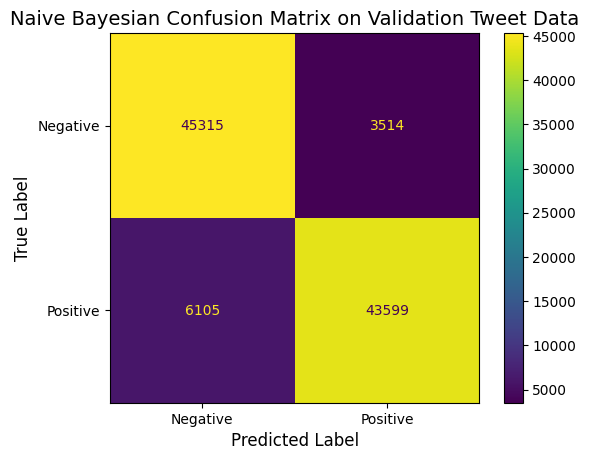

In [14]:
test_data["scores"] = [score(t) for t in test_data.Text.values]
test_data["pred_label"] = np.where(test_data["scores"] <= 0, 0, 1)
disp = ConfusionMatrixDisplay.from_predictions(
    test_target,
    test_data["pred_label"],
    display_labels=["Negative", "Positive"],
)
disp.ax_.set_title(
    "Naive Bayesian Confusion Matrix on Validation Tweet Data", fontsize=14
)
disp.ax_.set_xlabel("Predicted Label", fontsize=12)
disp.ax_.set_ylabel("True Label", fontsize=12)
plt.savefig("nb_cm", dpi=300)

In [15]:
accuracy_score(test_target, test_data["pred_label"])

0.9023778835517035

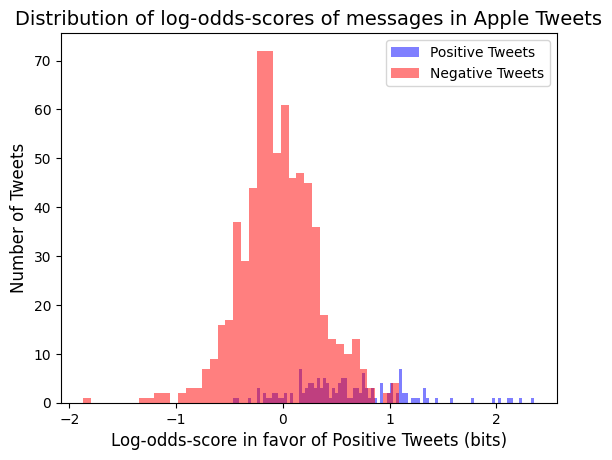

In [16]:
positive_scores = []
negative_scores = []
for t in apple_data.query("sentiment==1").text.values:
    positive_scores.append(score(t))
for t in apple_data.query("sentiment==0").text.values:
    negative_scores.append(score(t))
plt.hist(positive_scores, bins=100, color="blue", alpha=0.5, label="Positive Tweets")
plt.hist(negative_scores, bins=40, color="red", alpha=0.5, label="Negative Tweets")
plt.xlabel("Log-odds-score in favor of Positive Tweets (bits)", fontsize=12)
plt.ylabel("Number of Tweets", fontsize=12)
plt.title("Distribution of log-odds-scores of messages in Apple Tweets", fontsize=14)
# plt.xlim(-100, 150)
plt.legend()
plt.savefig("nb_dist", dpi=300)

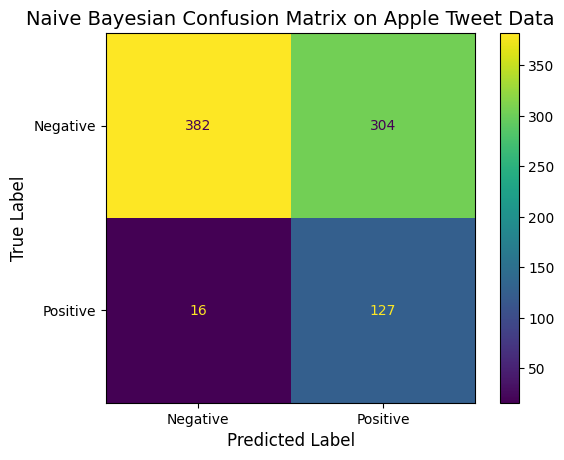

In [17]:
apple_data["scores"] = [score(t) for t in apple_data.text.values]
apple_data["pred_label"] = np.where(apple_data["scores"] <= 0, 0, 1)
disp = ConfusionMatrixDisplay.from_predictions(
    apple_data["sentiment"],
    apple_data["pred_label"],
    display_labels=["Negative", "Positive"],
)
disp.ax_.set_title("Naive Bayesian Confusion Matrix on Apple Tweet Data", fontsize=14)
disp.ax_.set_xlabel("Predicted Label", fontsize=12)
disp.ax_.set_ylabel("True Label", fontsize=12)
plt.savefig("nb_at_cm", dpi=300)

In [18]:
accuracy_score(apple_data["sentiment"], apple_data["pred_label"])

0.6139927623642943

## Bidirectional LSTM

In [19]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(train_data["Text"])
X_train = tokenizer.texts_to_sequences(train_data["Text"])
X_test = tokenizer.texts_to_sequences(test_data["Text"])

max_len = 200
X_train = tf.keras.preprocessing.sequence.pad_sequences(
    X_train, padding="post", maxlen=max_len
)
X_test = tf.keras.preprocessing.sequence.pad_sequences(
    X_test, padding="post", maxlen=max_len
)

y_train = to_categorical(train_target)
y_test = to_categorical(test_target)

# Input for variable-length sequences of integers
inputs = tf.keras.Input(shape=(None,), dtype="int32")
# Embed each integer in a 128-dimensional vector
x = layers.Embedding(10000, 128)(inputs)
# Add 2 bidirectional LSTMs
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Dropout(0.3)(x)  # Add a dropout layer with a rate of 0.3
x = layers.Bidirectional(layers.LSTM(64))(x)
x = layers.Dropout(0.3)(x)
# Add a classifier
outputs = layers.Dense(units=2, activation="sigmoid")(x)
model = tf.keras.Model(inputs, outputs)
model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    X_train,
    y_train,
    batch_size=256,  # can try 512
    epochs=2,
    validation_data=(X_test, y_test),
    workers=8,
)

Epoch 1/2
1540/1540 [==============================] - 1400s 908ms/step - loss: 0.1350 - accuracy: 0.9425 - val_loss: 0.0400 - val_accuracy: 0.9897
Epoch 2/2
1540/1540 [==============================] - 1404s 912ms/step - loss: 0.0326 - accuracy: 0.9915 - val_loss: 0.0323 - val_accuracy: 0.9903


26/26 [==============================] - 2s 43ms/step


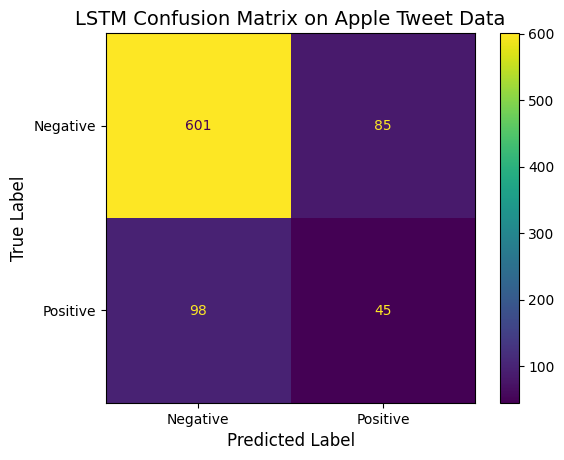

In [20]:
X_new = tokenizer.texts_to_sequences(apple_data["text"])
X_new = tf.keras.preprocessing.sequence.pad_sequences(
    X_new, padding="post", maxlen=max_len
)
y_new = to_categorical(apple_data["sentiment"])
y_pred = model.predict(X_new)
y_pred_labels = np.argmax(y_pred, axis=1)
disp = ConfusionMatrixDisplay.from_predictions(
    apple_data["sentiment"], y_pred_labels, display_labels=["Negative", "Positive"]
)
disp.ax_.set_title("LSTM Confusion Matrix on Apple Tweet Data", fontsize=14)
disp.ax_.set_xlabel("Predicted Label", fontsize=12)
disp.ax_.set_ylabel("True Label", fontsize=12)
plt.savefig("cm_lstm_at", dpi=300)
plt.show()

In [21]:
accuracy_score(apple_data["sentiment"], y_pred_labels)

0.7792521109770808

## Adding on GloVe's Twitter Pre-Trained Word Vector

In [22]:
embeddings_index = {}
embedding_dim = 100

# Load the pre-trained GloVe embeddings
glove_file = "/Users/Aadharsh/Downloads/classes/ML/project/glove.twitter.27B/glove.twitter.27B.100d.txt"
with open(glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print(f"Found {len(embeddings_index)} word vectors.")

# Create a word index based on the tokenized texts
word_index = tokenizer.word_index
num_words = min(10000, len(word_index)) + 1

# Initialize an embedding matrix with zeros
embedding_matrix = np.zeros((num_words, embedding_dim))

# Fill in the embedding matrix with the pre-trained GloVe embeddings
for word, i in word_index.items():
    if i >= num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embeddings index will be all zeros
        embedding_matrix[i] = embedding_vector

# Define the embedding layer with the pre-trained embeddings
embedding_layer = layers.Embedding(
    num_words,
    embedding_dim,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    input_length=max_len,
    trainable=False,
)
# Input for variable-length sequences of integers
inputs = tf.keras.Input(shape=(max_len,), dtype="int32")

# Replace the embedding layer with the pre-trained embedding layer
x = embedding_layer(inputs)

# Add 2 bidirectional LSTMs
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Dropout(0.3)(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
x = layers.Dropout(0.3)(x)

# Add a classifier
outputs = layers.Dense(units=2, activation="sigmoid")(x)

# Define the model
model2 = tf.keras.Model(inputs, outputs)

# Compile the model
model2.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model2.fit(
    X_train,
    y_train,
    batch_size=128,
    epochs=2,
    validation_data=(X_test, y_test),
    workers=8,
)

Found 1193514 word vectors.
Epoch 1/2
3080/3080 [==============================] - 1286s 417ms/step - loss: 0.0602 - accuracy: 0.9777 - val_loss: 0.0204 - val_accuracy: 0.9930
Epoch 2/2
3080/3080 [==============================] - 1265s 411ms/step - loss: 0.0197 - accuracy: 0.9932 - val_loss: 0.0186 - val_accuracy: 0.9934


26/26 [==============================] - 1s 43ms/step


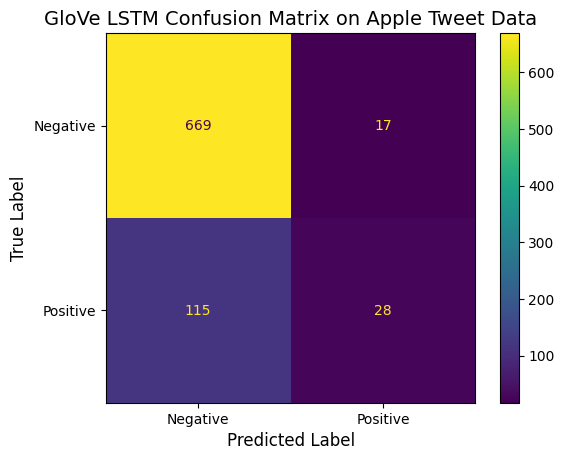

In [37]:
y_pred2 = model2.predict(X_new)
y_pred_labels2 = np.argmax(y_pred2, axis=1)
disp = ConfusionMatrixDisplay.from_predictions(
    apple_data["sentiment"], y_pred_labels2, display_labels=["Negative", "Positive"]
)
disp.ax_.set_title("GloVe LSTM Confusion Matrix on Apple Tweet Data", fontsize=14)
disp.ax_.set_xlabel("Predicted Label", fontsize=12)
disp.ax_.set_ylabel("True Label", fontsize=12)
plt.savefig("glove_cm", dpi=300)
plt.show()

In [25]:
accuracy_score(apple_data["sentiment"], y_pred_labels2)

0.8407720144752714

## CNN

In [33]:
# Create the embedding matrix using the pre-trained GloVe embeddings
embedding_dict = {}
with open(
    "/Users/Aadharsh/Downloads/classes/ML/project/glove.twitter.27B/glove.twitter.27B.100d.txt",
    "r",
    encoding="utf-8",
) as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype="float32")
        embedding_dict[word] = vector
word_index = tokenizer.word_index
num_words = min(10000, len(word_index) + 1)
embedding_dim = 100
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    if i >= num_words:
        continue
    embedding_vector = embedding_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Create the CNN model3 with GloVe embeddings
model3 = Sequential()
model3.add(
    Embedding(
        num_words,
        embedding_dim,
        embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
        input_length=max_len,
        trainable=False,
    )
)
model3.add(Conv1D(128, 5, activation="relu"))
model3.add(MaxPooling1D(pool_size=4))
model3.add(Dropout(0.3))
model3.add(Flatten())
model3.add(Dense(2, activation="sigmoid"))

# Compile the model3
model3.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Fit the model3
model3.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=4, batch_size=128)

Epoch 1/4
3080/3080 [==============================] - 100s 32ms/step - loss: 0.0841 - accuracy: 0.9704 - val_loss: 0.0358 - val_accuracy: 0.9883
Epoch 2/4
3080/3080 [==============================] - 96s 31ms/step - loss: 0.0367 - accuracy: 0.9880 - val_loss: 0.0318 - val_accuracy: 0.9897
Epoch 3/4
3080/3080 [==============================] - 100s 32ms/step - loss: 0.0319 - accuracy: 0.9896 - val_loss: 0.0332 - val_accuracy: 0.9887
Epoch 4/4
3080/3080 [==============================] - 99s 32ms/step - loss: 0.0295 - accuracy: 0.9905 - val_loss: 0.0314 - val_accuracy: 0.9902


26/26 [==============================] - 0s 3ms/step


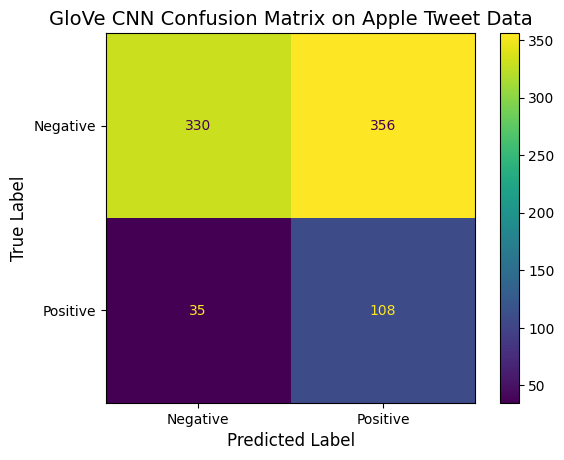

In [47]:
y_pred3 = model3.predict(X_new)
y_pred_labels3 = np.argmax(y_pred3, axis=1)
disp = ConfusionMatrixDisplay.from_predictions(
    apple_data["sentiment"], y_pred_labels3, display_labels=["Negative", "Positive"]
)
disp.ax_.set_title("GloVe CNN Confusion Matrix on Apple Tweet Data", fontsize=14)
disp.ax_.set_xlabel("Predicted Label", fontsize=12)
disp.ax_.set_ylabel("True Label", fontsize=12)
plt.savefig("glove_cnn_cm", dpi=300)
plt.show()

In [56]:
accuracy_score(apple_data["sentiment"], y_pred_labels3)

0.5283474065138721

what about a hybrid method that uses a weighted consensus between two or more?

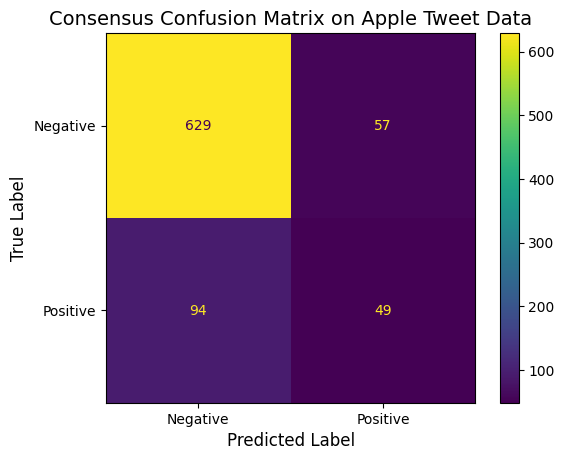

In [67]:
apple_data["LSTM_pred"] = y_pred_labels
apple_data["GloVe_pred"] = y_pred_labels2
apple_data["CNN_pred"] = y_pred_labels3
apple_data["agg_pred"] = (
    (apple_data["CNN_pred"] * 3) + apple_data["LSTM_pred"] + apple_data["GloVe_pred"]
) // 4
disp = ConfusionMatrixDisplay.from_predictions(
    apple_data["sentiment"],
    apple_data["agg_pred"],
    display_labels=["Negative", "Positive"],
)
disp.ax_.set_title("Consensus Confusion Matrix on Apple Tweet Data", fontsize=14)
disp.ax_.set_xlabel("Predicted Label", fontsize=12)
disp.ax_.set_ylabel("True Label", fontsize=12)
plt.savefig("cm_hybrid", dpi=300)
plt.show()

In [64]:
accuracy_score(apple_data["sentiment"], apple_data["agg_pred"])

0.8178528347406514

In [38]:
# add some apple tweets to training
apple_tweets = pd.read_csv("apple_tweets.csv")
apple_tweets = apple_tweets[apple_tweets.sentiment != 0]  # taking out neutral tweets
apple_tweets.loc[apple_tweets["sentiment"] == -1, "sentiment"] = 0
apple_tweets["text"] = apple_tweets["text"].apply(clean_text)
apple_tweets = apple_tweets.rename(columns={"text": "Text", "sentiment": "target"})
apple_tweets_train, apple_tweets_test, train_atarget, test_atarget = train_test_split(
    apple_tweets.drop("target", axis=1),
    apple_tweets.drop("Text", axis=1),
    random_state=42,
    test_size=0.8,
)
apple_tweets_train = tokenizer.texts_to_sequences(apple_tweets_train["Text"])
apple_tweets_train = tf.keras.preprocessing.sequence.pad_sequences(
    apple_tweets_train, padding="post", maxlen=max_len
)
apple_tweets_test = tokenizer.texts_to_sequences(apple_tweets_test["Text"])
apple_tweets_test = tf.keras.preprocessing.sequence.pad_sequences(
    apple_tweets_test, padding="post", maxlen=max_len
)
y_train_a = to_categorical(train_atarget)
model.fit(apple_tweets_train, y_train_a)
model2.fit(apple_tweets_train, y_train_a)
# call fit on these

6/6 [==============================] - 1s 132ms/step - loss: 0.5224 - accuracy: 0.8727


21/21 [==============================] - 1s 45ms/step


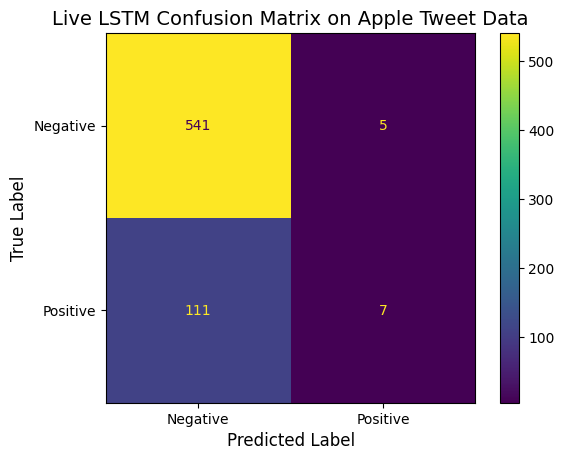

In [45]:
y_pred = model.predict(apple_tweets_test)
y_pred_labels4 = np.argmax(y_pred, axis=1)
y_test_a = to_categorical(test_atarget)
disp = ConfusionMatrixDisplay.from_predictions(
    test_atarget, y_pred_labels4, display_labels=["Negative", "Positive"]
)
disp.ax_.set_title("Live LSTM Confusion Matrix on Apple Tweet Data", fontsize=14)
disp.ax_.set_xlabel("Predicted Label", fontsize=12)
disp.ax_.set_ylabel("True Label", fontsize=12)

plt.savefig("dynamic_lstm_cm", dpi=300)
plt.show()

In [43]:
accuracy_score(test_atarget, y_pred_labels4)

0.8253012048192772

21/21 [==============================] - 1s 44ms/step


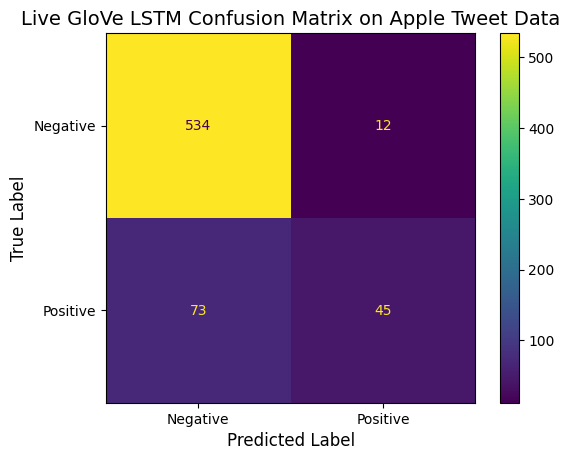

In [55]:
y_pred = model2.predict(apple_tweets_test)
y_pred_labels5 = np.argmax(y_pred, axis=1)
y_test_a = to_categorical(test_atarget)
disp = ConfusionMatrixDisplay.from_predictions(
    test_atarget, y_pred_labels5, display_labels=["Negative", "Positive"]
)
disp.ax_.set_title("Live GloVe LSTM Confusion Matrix on Apple Tweet Data", fontsize=14)
disp.ax_.set_xlabel("Predicted Label", fontsize=12)
disp.ax_.set_ylabel("True Label", fontsize=12)

plt.savefig("dynamic_glove_cm", dpi=300)
plt.show()

In [44]:
accuracy_score(test_atarget, y_pred_labels5)

0.8719879518072289